In [ ]:
import os
import shutil
from glob import glob

# Source directory where all images are stored
source_dir = "dataset/portrait-personality-3"
output_dir = "grouped_personality-3"

os.makedirs(output_dir, exist_ok=True)

# Get all jpg files
image_paths = glob(os.path.join(source_dir, "*.jpg"))

for img_path in image_paths:
    filename = os.path.basename(img_path)
    
    # Extract the video ID: everything before '.mp4-'
    if ".mp4-" in filename:
        video_id = filename.split(".mp4-")[0]
    else:
        continue  # Skip if doesn't follow pattern

    # Create a folder for this video ID if not exists
    video_folder = os.path.join(output_dir, video_id)
    os.makedirs(video_folder, exist_ok=True)

    # Destination path
    dest_path = os.path.join(video_folder, filename)
    shutil.copy2(img_path, dest_path)  # use shutil.move if you want to move

print("Images grouped into folders based on video ID.")


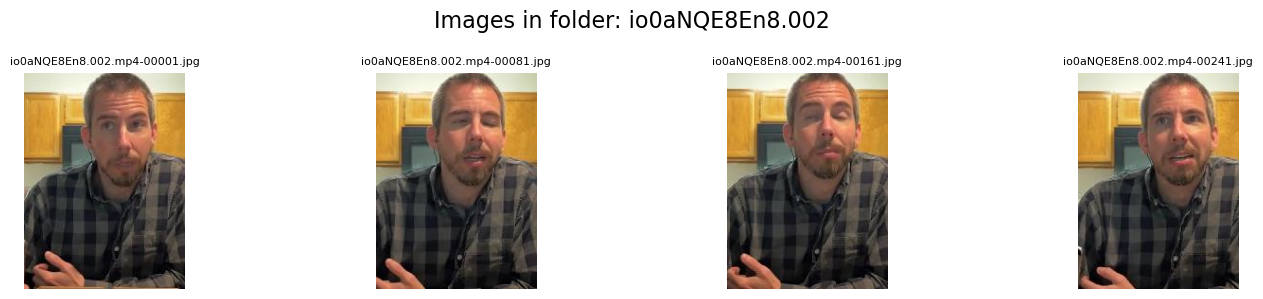

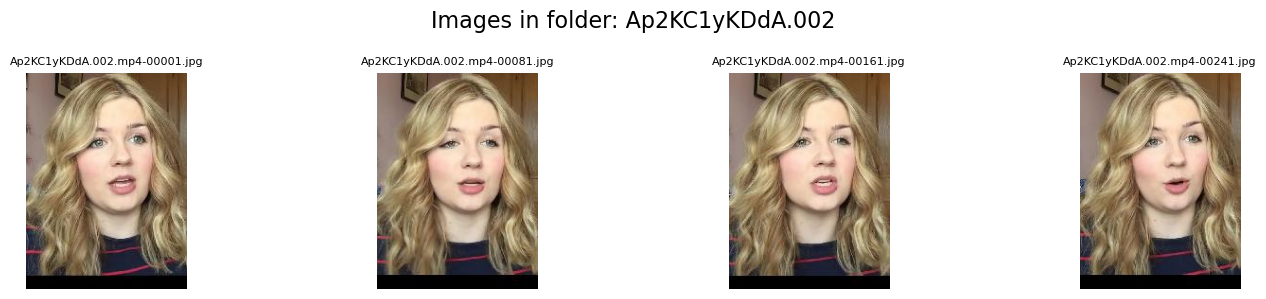

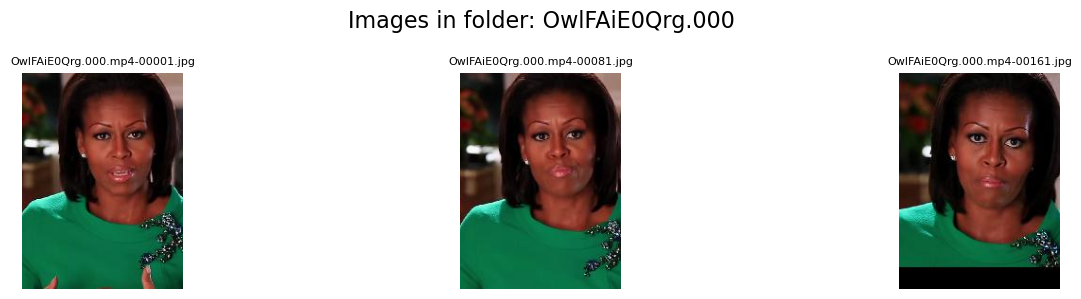

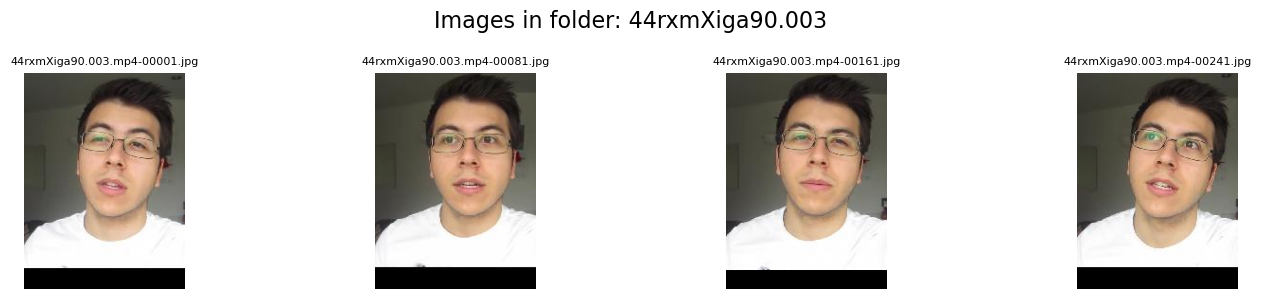

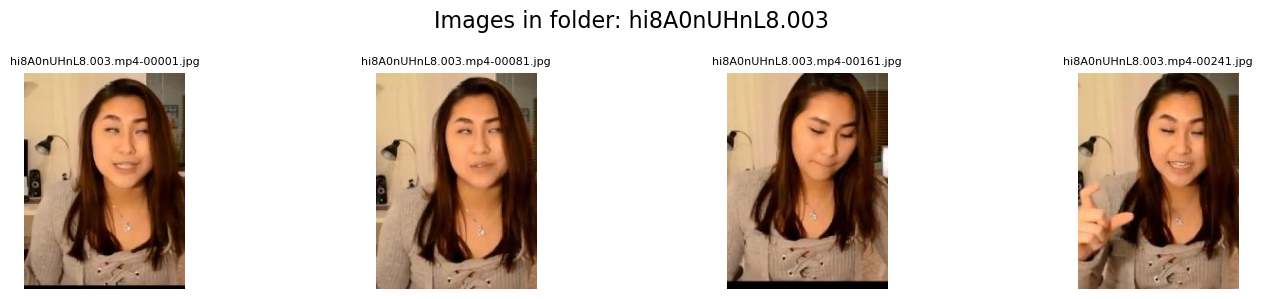

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your 'prepared_dataset' folder
base_path = 'prepared_dataset'

# Get all subfolder names
all_folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

# Select 5 random folders (or first 5 if you want)
# selected_folders = all_folders[:5]  # <-- First 5
selected_folders = random.sample(all_folders, 5)  # <-- Random 5 if you prefer

for folder_name in selected_folders:
    folder_path = os.path.join(base_path, folder_name)
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if images:
        n_images = len(images)
        n_cols = min(5, n_images)  # Max 5 images per row
        n_rows = (n_images + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
        axes = axes.flatten() if n_images > 1 else [axes]
        
        for idx, image_name in enumerate(images):
            img_path = os.path.join(folder_path, image_name)
            img = mpimg.imread(img_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(image_name, fontsize=8)
        
        # Hide unused subplots
        for idx in range(n_images, len(axes)):
            axes[idx].axis('off')
            
        plt.suptitle(f'Images in folder: {folder_name}', fontsize=16)
        plt.tight_layout()
        plt.show()


In [ ]:
# !pip install torch torchvision xgboost
# !pip install tqdm

In [6]:
import pandas as pd

# Load the CSV
df = pd.read_csv('dataset/bigfive_labels.csv')  # replace with your actual file name

# Show basic info about the CSV
print(df.info())

# Show the first few rows of data
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VideoName               8000 non-null   object 
 1   ValueExtraversion       8000 non-null   float64
 2   ValueAgreeableness      8000 non-null   float64
 3   ValueConscientiousness  8000 non-null   float64
 4   ValueNeurotisicm        8000 non-null   float64
 5   ValueOpenness           8000 non-null   float64
dtypes: float64(5), object(1)
memory usage: 375.1+ KB
None


,VideoName,ValueExtraversion,ValueAgreeableness,ValueConscientiousness,ValueNeurotisicm,ValueOpenness
0,GQczMGrVgbc.001.mp4,0.570093,0.703297,0.640777,0.666667,0.544444
1,-utrsarZeIY.004.mp4,0.523364,0.516484,0.436893,0.333333,0.411111
2,3HA2W1s4oP8.001.mp4,0.401869,0.538462,0.427184,0.510417,0.388889
3,hM96SfN5_F4.004.mp4,0.485981,0.637363,0.359223,0.458333,0.566667
4,SgzOYog1pH4.003.mp4,0.532710,0.527473,0.650485,0.458333,0.477778


In [7]:
df.columns

Index(['VideoName', 'ValueExtraversion', 'ValueAgreeableness',
       'ValueConscientiousness', 'ValueNeurotisicm', 'ValueOpenness'],
      dtype='object')

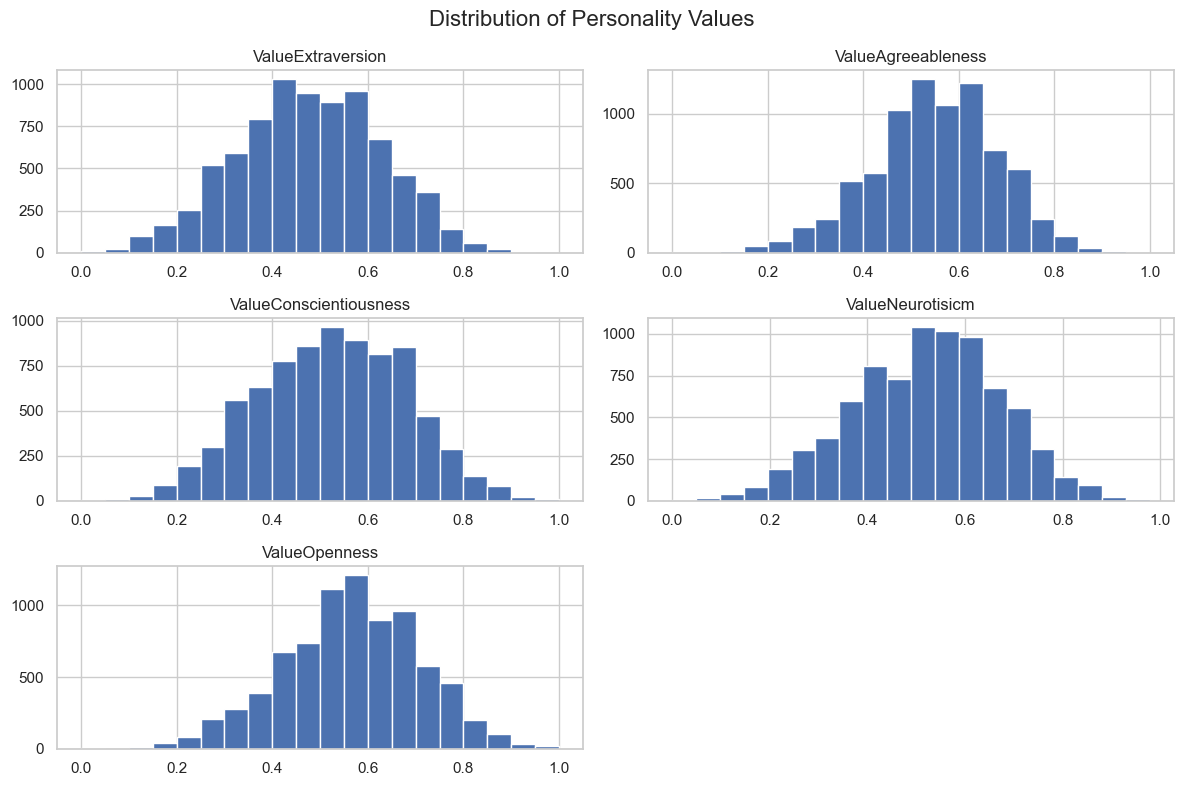

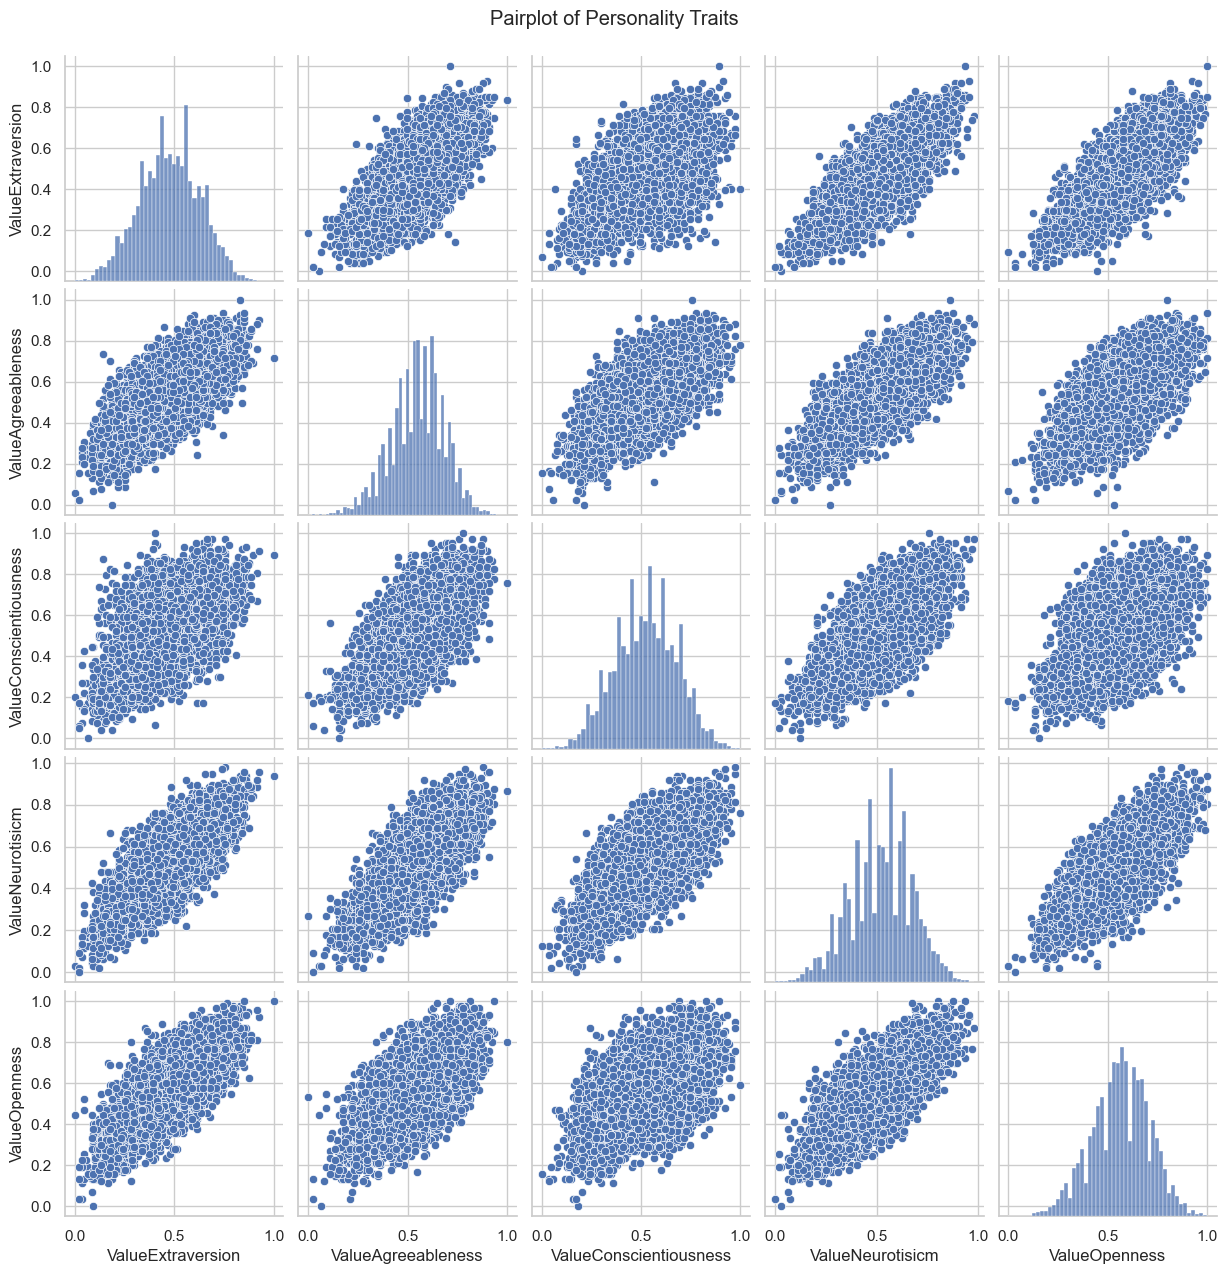

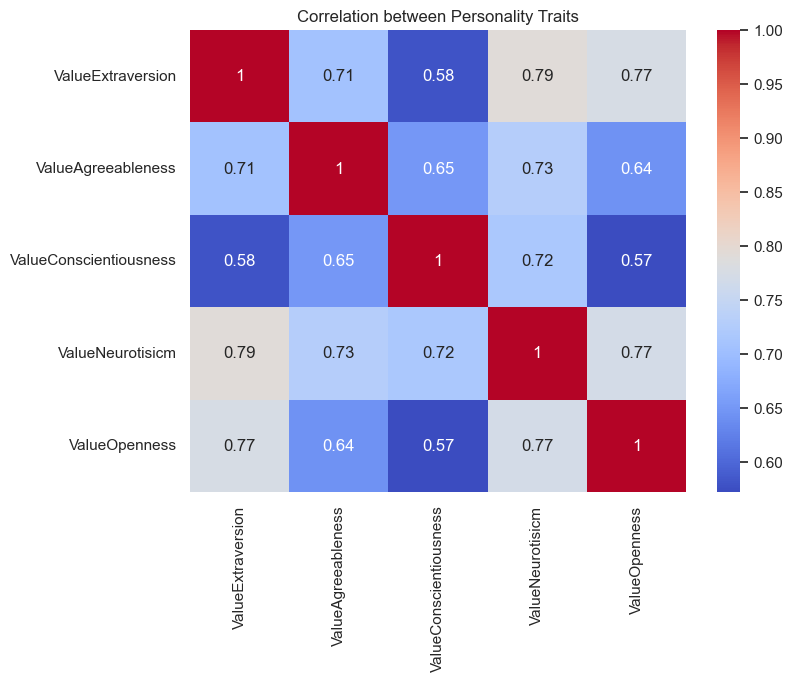

In [8]:
import seaborn as sns
# Drop 'VideoName' because it's not numeric
numeric_df = df.drop(columns=['VideoName'])

# Set the style
sns.set(style="whitegrid")

# Plot histograms for each numeric column
numeric_df.hist(figsize=(12, 8), bins=20)
plt.suptitle('Distribution of Personality Values', fontsize=16)
plt.tight_layout()
plt.show()

# Plot pairplot to see relationships between features
sns.pairplot(numeric_df)
plt.suptitle('Pairplot of Personality Traits', y=1.02)
plt.show()

# Plot a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Personality Traits')
plt.show()

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

# Paths
csv_path = "dataset/bigfive_labels.csv"
image_root = "prepared_dataset"

# Load CSV and strip '.mp4' for matching
df = pd.read_csv(csv_path)
df["VideoID"] = df["VideoName"].str.replace(".mp4", "", regex=False)

# Image transform (same as ResNet expects)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained ResNet50 model (remove classification head)
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # remove final FC
resnet.eval().cuda()

def extract_features_from_folder(folder_path):
    features = []
    for img_name in os.listdir(folder_path):
        if not img_name.endswith(".jpg"):
            continue
        img_path = os.path.join(folder_path, img_name)
        image = Image.open(img_path).convert("RGB")
        image = transform(image).unsqueeze(0).cuda()  # Add batch dimension
        with torch.no_grad():
            feature = resnet(image).squeeze().cpu().numpy()  # Flatten output
        features.append(feature)
    if len(features) == 0:
        return None
    return np.mean(features, axis=0)  # Average pooling

# Loop through folders and build dataset
X = []
y = []
failed = []

for folder in tqdm(os.listdir(image_root)):
    folder_path = os.path.join(image_root, folder)
    if not os.path.isdir(folder_path):
        continue

    features = extract_features_from_folder(folder_path)
    if features is None:
        failed.append(folder)
        continue

    # Match to CSV row
    row = df[df["VideoID"] == folder]
    if row.empty:
        failed.append(folder)
        continue

    labels = row.iloc[0, 1:6].values.astype(np.float32)  # assuming label cols 1–5
    X.append(features)
    y.append(labels)

# Final arrays
X = np.array(X)
y = np.array(y)
print(f"Feature matrix shape: {X.shape}")
print(f"Label matrix shape: {y.shape}")


c:\Users\muham\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\muham\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 7997/7997 [03:48<00:00, 34.97it/s]

Feature matrix shape: (7997, 2048)
Label matrix shape: (7997, 5)


Saving the extracted features with its labels as numpy not to loose

In [ ]:
import numpy as np
# Save extracted features and labels as .npy files
np.save("features_X.npy", X)
np.save("labels_y.npy", y)

print("Saved features to 'features_X.npy' and labels to 'labels_y.npy'")


In [3]:
import numpy as np
# Load features and labels
X = np.load("features_X.npy")
y = np.load("labels_y.npy")

In [4]:
import random

# Pick 5 random indices
sample_indices = random.sample(range(len(X)), 5)

# Print samples
for idx in sample_indices:
    print(f"Sample {idx}:")
    print(f"Feature (X): {X[idx]}")
    print(f"Label (y): {y[idx]}")
    print("-" * 50)


Sample 5244:
Feature (X): [0.38348648 1.0452025  0.9322463  ... 0.15003943 0.284437   0.18229629]
Label (y): [0.5233645  0.48351648 0.74757284 0.59375    0.64444447]
--------------------------------------------------
Sample 4855:
Feature (X): [0.07972641 0.47333866 1.0153444  ... 0.04314785 0.15563235 0.13507067]
Label (y): [0.6448598  0.5714286  0.60194176 0.6875     0.64444447]
--------------------------------------------------
Sample 5273:
Feature (X): [0.05104446 1.4313692  0.23281355 ... 0.18888664 0.03999566 0.01187197]
Label (y): [0.18691589 0.2747253  0.3398058  0.16666667 0.26666668]
--------------------------------------------------
Sample 6696:
Feature (X): [0.04413128 1.2332973  1.5147927  ... 0.40449178 0.45888293 0.06525211]
Label (y): [0.5046729 0.5824176 0.6893204 0.5833333 0.3888889]
--------------------------------------------------
Sample 7225:
Feature (X): [0.53705096 1.4096302  0.7221326  ... 0.36604178 0.8923405  0.5475119 ]
Label (y): [0.58878505 0.85714287 0.699

In [3]:
X.shape, y.shape

((7997, 2048), (7997, 5))

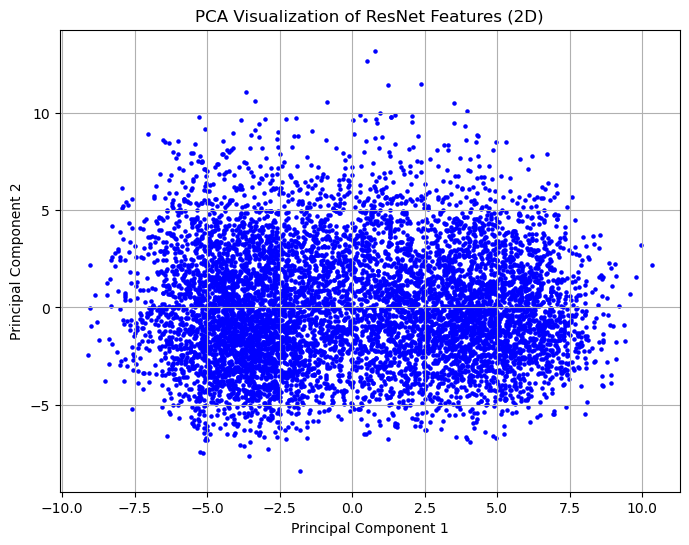

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 components just for visualization
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c='blue', s=5)  # you can also color by y if classification
plt.title('PCA Visualization of ResNet Features (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [7]:
# 2. Apply PCA
pca = PCA(n_components=300)  # you can choose 100, 200, 300 depending on how small you want
X_reduced = pca.fit_transform(X)


=== RandomForest ===
             RMSE       MAE        R²  Explained Variance  Max Error  \
Trait 1  0.128439  0.101911  0.297944            0.297954   0.410093   
Trait 2  0.120156  0.101911  0.210899            0.211255   0.403626   
Trait 3  0.127789  0.101911  0.325491            0.325901   0.407670   
Trait 4  0.135292  0.101911  0.254248            0.255331   0.537083   
Trait 5  0.126895  0.101911  0.249541            0.249647   0.439111   
Average  0.127714  0.101911  0.267625            0.268018   0.439517   

         Median AE  
Trait 1   0.088505  
Trait 2   0.083407  
Trait 3   0.085194  
Trait 4   0.093906  
Trait 5   0.085556  
Average   0.087313  


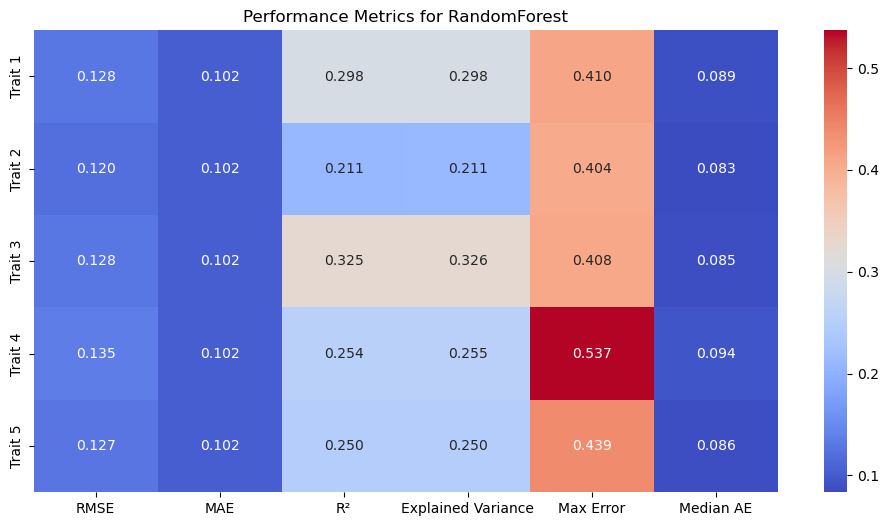


=== GradientBoosting ===
             RMSE       MAE        R²  Explained Variance  Max Error  \
Trait 1  0.133619  0.105821  0.240175            0.240183   0.439795   
Trait 2  0.126147  0.105821  0.130255            0.130899   0.435367   
Trait 3  0.130799  0.105821  0.293342            0.293754   0.420306   
Trait 4  0.141745  0.105821  0.181405            0.181928   0.559070   
Trait 5  0.129452  0.105821  0.219001            0.219403   0.505720   
Average  0.132352  0.105821  0.212836            0.213233   0.472052   

         Median AE  
Trait 1   0.090590  
Trait 2   0.084785  
Trait 3   0.088754  
Trait 4   0.098100  
Trait 5   0.086466  
Average   0.089739  


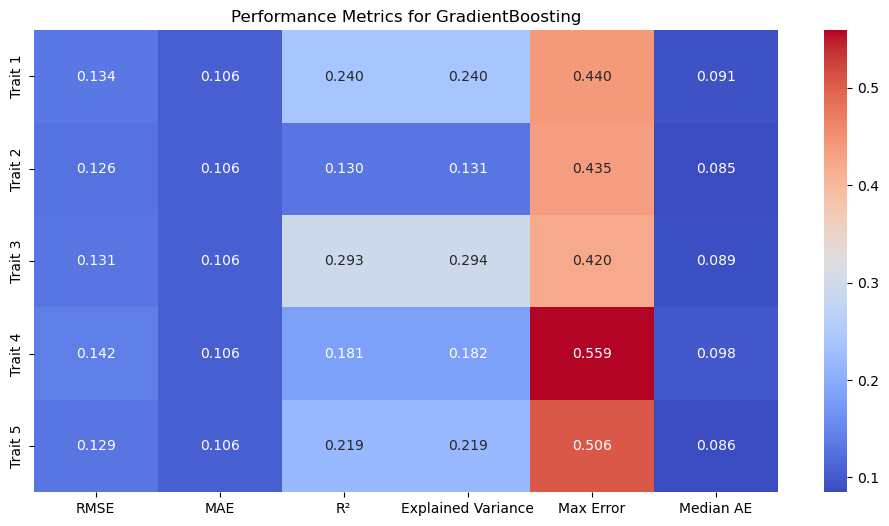


=== Ridge ===
             RMSE       MAE        R²  Explained Variance  Max Error  \
Trait 1  0.131278  0.104315  0.266563            0.266569   0.446874   
Trait 2  0.126705  0.104315  0.122538            0.123352   0.437136   
Trait 3  0.125992  0.104315  0.344326            0.344402   0.457257   
Trait 4  0.140424  0.104315  0.196591            0.196948   0.580261   
Trait 5  0.128675  0.104315  0.228343            0.228881   0.525379   
Average  0.130615  0.104315  0.231672            0.232031   0.489381   

         Median AE  
Trait 1   0.086733  
Trait 2   0.085047  
Trait 3   0.083687  
Trait 4   0.096360  
Trait 5   0.087993  
Average   0.087964  


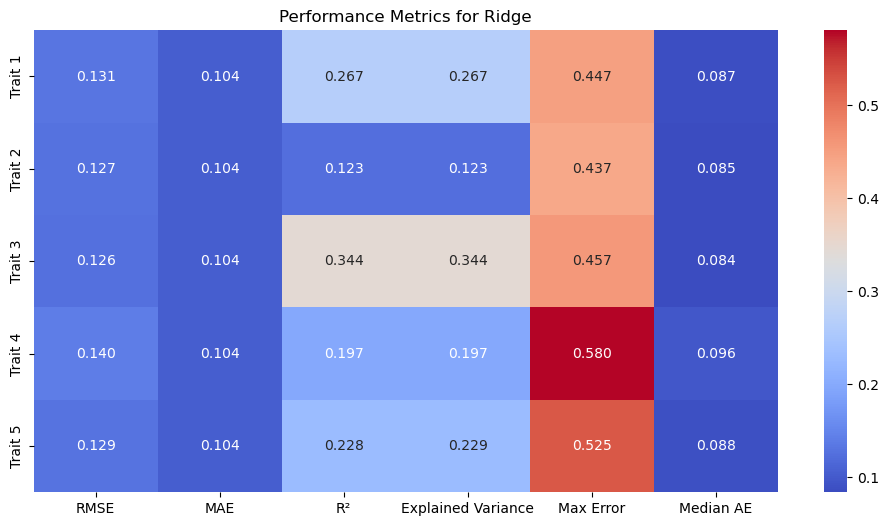


=== SVR ===
             RMSE       MAE        R²  Explained Variance  Max Error  \
Trait 1  0.117989  0.094084  0.407539            0.407718   0.456109   
Trait 2  0.116018  0.094084  0.264319            0.264606   0.434439   
Trait 3  0.112459  0.094084  0.477619            0.477890   0.392957   
Trait 4  0.126813  0.094084  0.344796            0.346956   0.544676   
Trait 5  0.119046  0.094084  0.339514            0.339575   0.409408   
Average  0.118465  0.094084  0.366757            0.367349   0.447518   

         Median AE  
Trait 1   0.076108  
Trait 2   0.077190  
Trait 3   0.075986  
Trait 4   0.084447  
Trait 5   0.080775  
Average   0.078901  


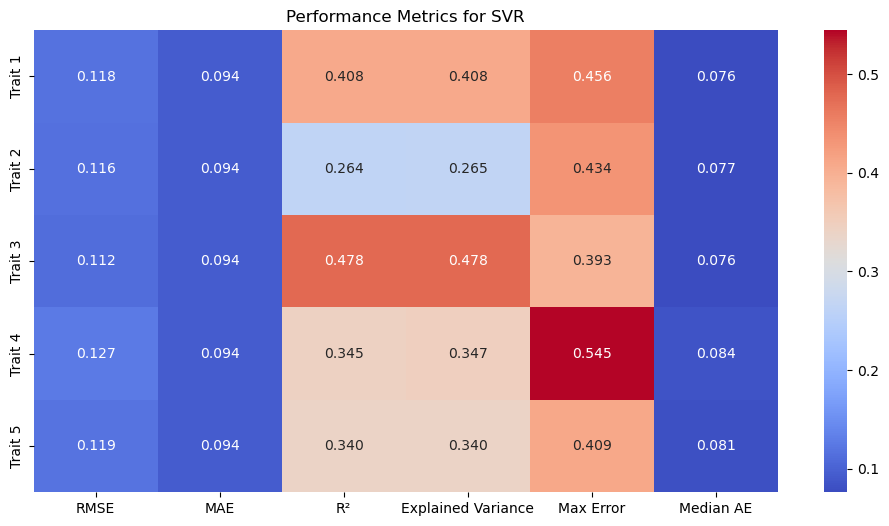


=== XGBoost ===
             RMSE       MAE        R²  Explained Variance  Max Error  \
Trait 1  0.130586  0.103001  0.274277            0.274311   0.413921   
Trait 2  0.125843  0.103001  0.134437            0.134990   0.459148   
Trait 3  0.124858  0.103001  0.356084            0.356558   0.405049   
Trait 4  0.137802  0.103001  0.226319            0.226714   0.530951   
Trait 5  0.127931  0.103001  0.237245            0.237657   0.441723   
Average  0.129404  0.103001  0.245672            0.246046   0.450158   

         Median AE  
Trait 1   0.086731  
Trait 2   0.082700  
Trait 3   0.083478  
Trait 4   0.090926  
Trait 5   0.085178  
Average   0.085803  


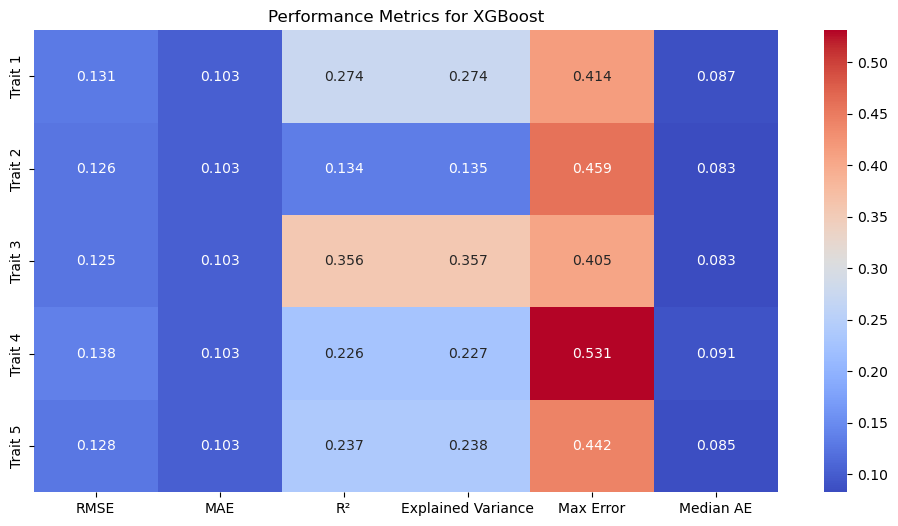

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    explained_variance_score, max_error, median_absolute_error
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
import warnings
warnings.filterwarnings("ignore")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Define regression models
models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=100,
        n_jobs=-1,
        random_state=42
    ),
    "GradientBoosting": MultiOutputRegressor(
        GradientBoostingRegressor(
            n_estimators=100,
            random_state=42
        )
    ),
    "Ridge": Ridge(alpha=1.0),
    "SVR": MultiOutputRegressor(SVR()),
    "XGBoost": MultiOutputRegressor(
        XGBRegressor(
            n_estimators=100,
            tree_method="hist",
            enable_categorical=False,
            random_state=42
        )
    )
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n=== {name} ===")

    # Train
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, preds, multioutput='raw_values'))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds, multioutput='raw_values')
    expl_var = explained_variance_score(y_test, preds, multioutput='raw_values')
    max_err = [max_error(y_test[:, i], preds[:, i]) for i in range(y.shape[1])]
    med_ae = [median_absolute_error(y_test[:, i], preds[:, i]) for i in range(y.shape[1])]

    # Create metrics dictionary
    metrics_dict = {
        "RMSE": rmse,
        "MAE": [mae] * len(rmse),
        "R²": r2,
        "Explained Variance": expl_var,
        "Max Error": max_err,
        "Median AE": med_ae,
    }

    # Make DataFrame
    metrics_df = pd.DataFrame(metrics_dict, index=[f"Trait {i+1}" for i in range(len(rmse))])

    # Add averages
    averages = {
        "RMSE": np.mean(rmse),
        "MAE": np.mean(mae),
        "R²": np.mean(r2),
        "Explained Variance": np.mean(expl_var),
        "Max Error": np.mean(max_err),
        "Median AE": np.mean(med_ae),
    }
    metrics_df.loc["Average"] = averages

    # Display DataFrame
    print(metrics_df)

    # Plot as heatmap (except Average row)
    plt.figure(figsize=(12, 6))
    sns.heatmap(metrics_df.iloc[:-1].astype(float), annot=True, fmt=".3f", cmap="coolwarm")
    plt.title(f"Performance Metrics for {name}")
    plt.show()


In [9]:
oof_train_preds = []
test_preds = []

for name, model in models.items():
    print(f"Training {name}")

    # Train normally
    model.fit(X_train, y_train)

    # Predict on train and test directly
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    oof_train_preds.append(train_pred)
    test_preds.append(test_pred)

# Stack horizontally
stacked_train = np.hstack(oof_train_preds)
stacked_test = np.hstack(test_preds)

print("Stacked train shape:", stacked_train.shape)
print("Stacked test shape:", stacked_test.shape)



Training RandomForest
Training GradientBoosting
Training Ridge
Training SVR
Training XGBoost
Stacked train shape: (6397, 25)
Stacked test shape: (1600, 25)



=== Deep Super Learner Meta-Model Metrics ===
             RMSE       MAE        R²  Explained Variance  Max Error  \
Trait 1  0.123926  0.098022  0.346409            0.346466   0.397944   
Trait 2  0.118971  0.098022  0.226393            0.227063   0.424615   
Trait 3  0.120147  0.098022  0.403754            0.404350   0.380631   
Trait 4  0.130677  0.098022  0.304253            0.304854   0.539115   
Trait 5  0.122469  0.098022  0.300984            0.301077   0.437778   
Average  0.123238  0.098022  0.316359            0.316762   0.436017   

         Median AE  
Trait 1   0.082570  
Trait 2   0.080412  
Trait 3   0.082233  
Trait 4   0.086510  
Trait 5   0.081917  
Average   0.082728  


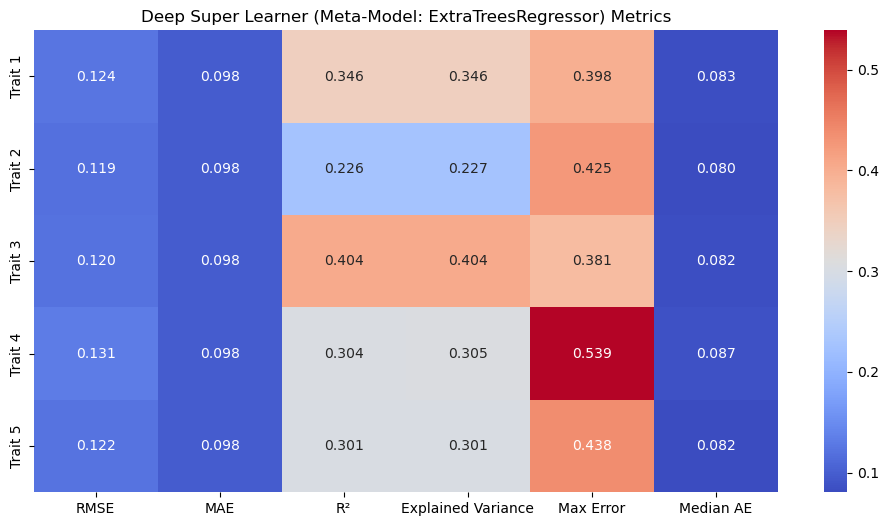

In [10]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Define the Meta-Learner
meta_model = ExtraTreesRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Step 2: Train Meta-Learner
meta_model.fit(stacked_train, y_train)

# Step 3: Predict with Meta-Learner
meta_preds = meta_model.predict(stacked_test)

# Step 4: Evaluate Meta-Learner
rmse = np.sqrt(mean_squared_error(y_test, meta_preds, multioutput='raw_values'))
mae = mean_absolute_error(y_test, meta_preds)
r2 = r2_score(y_test, meta_preds, multioutput='raw_values')
expl_var = explained_variance_score(y_test, meta_preds, multioutput='raw_values')
max_err = [max_error(y_test[:, i], meta_preds[:, i]) for i in range(y.shape[1])]
med_ae = [median_absolute_error(y_test[:, i], meta_preds[:, i]) for i in range(y.shape[1])]

# Step 5: Create a Metrics Table
metrics_dict = {
    "RMSE": rmse,
    "MAE": [mae] * len(rmse),
    "R²": r2,
    "Explained Variance": expl_var,
    "Max Error": max_err,
    "Median AE": med_ae,
}

metrics_df = pd.DataFrame(metrics_dict, index=[f"Trait {i+1}" for i in range(len(rmse))])

# Add averages
averages = {
    "RMSE": np.mean(rmse),
    "MAE": np.mean(mae),
    "R²": np.mean(r2),
    "Explained Variance": np.mean(expl_var),
    "Max Error": np.mean(max_err),
    "Median AE": np.mean(med_ae),
}
metrics_df.loc["Average"] = averages

# Step 6: Show the Final Results
print("\n=== Deep Super Learner Meta-Model Metrics ===")
print(metrics_df)

# Step 7: Plot the Final Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(metrics_df.iloc[:-1].astype(float), annot=True, fmt=".3f", cmap="coolwarm")
plt.title(f"Deep Super Learner (Meta-Model: ExtraTreesRegressor) Metrics")
plt.show()


In [11]:
import joblib

# Save the meta-model
joblib.dump(meta_model, "deep_super_learner_meta_model.pkl")
print("Meta-model saved successfully.")


Meta-model saved successfully.
